In [1]:
# importing the libraries
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec, KeyedVectors
from datasets import load_dataset
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import warnings
from pandas.core.common import SettingWithCopyWarning

In [2]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
# downloading nltk.punkt
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

### Defining relevant functions

In [4]:
def word_cloud_plot (data):
    """
    function that creates a word cloud from a specified column of a dataframe 
    """
    # create set of stopwords
    stopwords = set(STOPWORDS)

    # Instantiate the word cloud object
    word_cloud = WordCloud(background_color='white',max_words=200,stopwords=stopwords, width=800, height=400)
    
    # generate the word cloud
    word_cloud.generate(' '.join(data))
    
    # To display the word cloud
    plt.figure( figsize=(20,10) )
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [5]:
def regex_filter(sentence):
    """
    funtion that formats string to remove special characters
    """
    import re
    return re.sub('[^a-zA-Z]', ' ', sentence)

In [6]:
def filter_stop_words(token):
    """
    function that removes stopwords from a word-tokenized sentence
    """
    stop_words = set(stopwords.words('english'))
    filtered_token = [word.lower() for word in token if word.lower() not in stop_words]
    return filtered_token

In [7]:
def stem_words(token):
    """
    function that stems word-tokenized sentences
    """
    ps = PorterStemmer()
    stemmed_token = [ps.stem(word) for word in token]
    return stemmed_token

In [8]:
def lemmatize_words(token):
    """
    function that lemmatizes word-tokenized sentences
    """
    lem = WordNetLemmatizer()
    lemmatized_token = [lem.lemmatize(word, 'v') for word in token]
    return lemmatized_token

In [9]:
def join_token(token):
    """
    function that joins word-tokenized sentences back to single string
    """
    return ' '.join(token)

In [10]:
def get_embeddings(group, model):
    """
    Function for getting embeddings of words from a word2vec model 
    """
    group_embedding = []
    group_labels = []
    
    unique_words = [word for sentence in group for word in sentence]
    unique_words = list(dict.fromkeys(unique_words))
    
    for word in unique_words:
        if model.wv.__contains__(word):
            group_embedding.append(list(model.wv.__getitem__(word)))
            group_labels.append(word)
            
    df_embedding = pd.DataFrame(group_embedding)
    df_word = pd.DataFrame(group_labels, columns = ["Word"])
    df = pd.concat([df_word, df_embedding], axis=1)
    return df

In [11]:
def similarity(words, stem_model=None, lem_model=None, W2V_pretrained=None, GloVe_pretrained=None):
    """
    function that computes similarity between words for up to four models passed 
    """
    if stem_model:
        ps = PorterStemmer()
        stemmed = [ps.stem(word) for word in words]
        try:
            print("Stemmed W2V model similarity between", words[0], "and", words[1], "=", round(stem_model.wv.similarity(stemmed[0], stemmed[1]), 2))
        except:
            print("Error: Word not in stem model vocabulary")
    
    if lem_model:
        lem = WordNetLemmatizer()
        lemma = [lem.lemmatize(word, 'v') for word in words]
        try:
            print("Lemmatized W2V model similarity between", words[0], "and", words[1], "=", round(lem_model.wv.similarity(lemma[0], lemma[1]), 2))
        except:
            print("Error: Word not in lemmatized model vocabulary")        
    
    if W2V_pretrained:
        try:
            print("Word2vec pretrained model similarity between", words[0], "and", words[1], "=", round(W2V_pretrained.wv.similarity(words[0], words[1]), 2))
        except:
            print("Error: Word not in Word2vec pretrained model vocabulary")
    
    if GloVe_pretrained:
        try:
            print("GloVe pretrained model similarity between", words[0], "and", words[1], "=", round(GloVe_pretrained.similarity(words[0], words[1]), 2))
        except:
            print("Error: Word not in GloVe pretrained model vocabulary")    

In [12]:
def tsne_plot(df):
    """
    function that plots annotated scatter plot from a dataframe
    """
    plt.figure(figsize=(18, 18)) 
    for i in range(len(df)):
        plt.scatter(df.iloc[i,1],df.iloc[i,2])
        plt.annotate(df.iloc[i,0],
                     xy=(df.iloc[i,1], df.iloc[i,2]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [13]:
def get_sentence_embedding(data, column, train_word_embedding, test_word_embedding):
    """
    function that creates a sentence embedding from the embeddings of the individual words
    sentence_embedding = average of word embeddings for all words in the sentence
    """
    data.reset_index(inplace=True, drop = True)
    sentence_embeddings = []
    for token in data[column]:
        embeddings = []
        for word in token:
            if word in train_word_embedding.index:
                embeddings.append(train_word_embedding.loc[word])
            else:
                embeddings.append(test_word_embedding.loc[word])
        
        embedding_array = np.array(embeddings)
        sentence_embedding = np.mean(embedding_array, axis=0)
        sentence_embeddings.append(list(sentence_embedding))
        
    features = len(sentence_embeddings[0])
    df = pd.DataFrame(sentence_embeddings, columns = ["feature_"+ str(i+1) for i in range(features)])
    df = pd.concat([data["claim"], df, data["claim_label"]], axis=1)
    return df   

In [14]:
def get_most_similar_words(embedding, n_similar = 1):
    """
    function that returns n_similar most similar words to a particular word in an embedding. 
    embedding is n x n square matrix of relationship (similarity) between words
    """
    n_similar += 1
    similar = pd.DataFrame(columns = ['most_similar_'+ str(i) for i in range(1, n_similar)])
    
    embedding_T = embedding.T
    for word in embedding.index:
        most_similar = list(embedding_T.nlargest(n = n_similar, columns = word).index)
        if word in most_similar:
            most_similar.remove(word)
        else:
            most_similar = most_similar[:-1]
            
        similar.loc[word] = most_similar
    
    return similar

In [15]:
def precision_recall_fscore(y_true, y_pred):
    """
    function that computes the precision, recall and fscore between 2 dataframes across n_columns columns
    returns the average precision, recall and fscore across the n_columns
    """
    if len(y_true) != len(y_pred):
        print("Error in dimensions of inputs")
        return
    
    n_columns = len(y_true)
    metrics = []
    
    for i in range(n_columns):
        metric = list(precision_recall_fscore_support(y_true.iloc[:,i], y_pred.iloc[:,i], average='macro'))
        metrics.append(metric[:-1])
       
    metrics = np.mean(np.array(metrics), axis=0)
        
    print("Precision: ", round(metrics[0], 2))
    print("Recall: ", round(metrics[1], 2))
    print("F1_score: ", round(metrics[2], 2))
    

In [16]:
def run_knn_opt(X_train, X_val, X_test, y_train, y_val, y_test, k_values):
    """
    function that performs tunning of k_parameter in KNN classifier
    produces confusion matrix, accuracy, fscore and screeplots
    """
    # Developing the Classification Model
    classifier = KNeighborsClassifier()
    classifier.fit(X_train,y_train)

    # Predicting the test set result
    y_pred = classifier.predict(X_test)

    # Evaluating the Model
    cm = confusion_matrix(y_test,y_pred)

    accuracy_1 = round(100 * accuracy_score(y_test,y_pred), 2)
    f1_score_1 = round(f1_score(y_test, y_pred, average = "weighted"), 2)

    y_pred_train  = classifier.predict(X_train)
    
    # Making the Confusion Matrix
    cm_train = pd.DataFrame(confusion_matrix(y_train,y_pred_train))
    cm_test = pd.DataFrame(confusion_matrix(y_test,y_pred))

    print("***** Training Set Evaluation *****\n")
    print("confusion Matrix")
    display(cm_train)
    print("Accuracy: ", round(100 * accuracy_score(y_train, y_pred_train), 2))
    print("F1_score: ", round(f1_score(y_train, y_pred_train, average = 'weighted'), 2))
    
    print("\n\n***** Test Set Evaluation *****\n")
    print("confusion Matrix")
    display(cm_test)
    print("Accuracy: ", accuracy_1)
    print("F1_score: ", f1_score_1)
    
    accuracy = {}
    for k in k_values:
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train,y_train)

        # Predicting the test set result
        y_pred = classifier.predict(X_val)

        model_accuracy = accuracy_score(y_val, y_pred)

        accuracy[k] = round(model_accuracy * 100, 2)
        
    # plotting the parameter vs accuracy graph
    sns.lineplot(x = k_values, y = accuracy.values())

### Downloading the dataset

In [17]:
dataset = load_dataset('climate_fever')

df = dataset['test'].to_pandas()
df2 = pd.json_normalize(dataset['test'], 'evidences', ['claim', 'claim_id','claim_label'], errors='ignore',record_prefix='')

data1 = df[['claim', 'claim_label']]
data2 = df2[['evidence','evidence_label']]

Using custom data configuration default
Reusing dataset climate_fever (C:\Users\jubil\.cache\huggingface\datasets\climate_fever\default\1.0.1\3b846b20d7a37bc0019b0f0dcbde5bf2d0f94f6874f7e4c398c579f332c4262c)


# Data preparation

### Claim Data

In [18]:
# filter with regex
data1.loc[:, 'claim_token'] = data1.loc[:, 'claim'].apply(regex_filter)

# Tokenizing the claims
data1.loc[:, 'claim_token'] = data1.loc[:, 'claim_token'].apply(nltk.word_tokenize)

# Removing stop words from the claclaim_tokenim tokens
data1.loc[:,'claim_token'] = data1.loc[:,'claim_token'].apply(filter_stop_words)

# Stemming the words
data1.loc[:,'stemmed_words'] = data1.loc[:,'claim_token'].apply(stem_words)

# lemmatizing the words
data1.loc[:,'lemmatized_words'] = data1.loc[:,'claim_token'].apply(lemmatize_words)

### Evidence Data

In [19]:
# Adding the evidences to increase corpus size

# filer with regex
data2.loc[:, ('evidence_token')] = data2.loc[:, ('evidence')].apply(regex_filter)

# Tokenizing the claims
data2.loc[:, ('evidence_token')] = data2.loc[:, ('evidence_token')].apply(nltk.word_tokenize)

# Removing stop words from the evidence_token tokens
data2.loc[:,('evidence_token')] = data2.loc[:,('evidence_token')].apply(filter_stop_words)

# Stemming the words
data2.loc[:,('stemmed_words')] = data2.loc[:,('evidence_token')].apply(stem_words)

# lemmatizing the words
data2.loc[:,('lemmatized_words')] = data2.loc[:,('evidence_token')].apply(lemmatize_words)

In [20]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data1[['claim', 'stemmed_words', 'lemmatized_words', 'claim_label']], test_size=0.2, random_state=0)

In [21]:
# creating the stemmed corpus and lemmatized corpus
corpus_stem = list(data1['stemmed_words']) + list(data2['stemmed_words'])
corpus_lem = list(data1['lemmatized_words']) + list(data2['stemmed_words'])

In [22]:
# Embeding with Word2Vec
model_stem = Word2Vec(corpus_stem, min_count=1)
model_lem = Word2Vec(corpus_lem, min_count=1)
print(model_stem)
print(model_lem)

Word2Vec(vocab=7433, size=100, alpha=0.025)
Word2Vec(vocab=8894, size=100, alpha=0.025)


In [23]:
# Training set embedings [STEMMING]
train_embedding_stem = get_embeddings(list(train_data['stemmed_words']), model_stem)
train_embedding_stem.set_index("Word", inplace=True)
train_embedding_stem.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Word,,,,,,,,,,,,,,,,,,,,,
pdo,-0.058069,-0.095615,-0.171844,-0.071858,-0.079601,0.101760,-0.038534,0.350794,-0.281112,0.116810,...,0.105646,-0.103784,-0.026147,-0.116719,-0.222574,0.076068,-0.056096,0.120679,-0.027422,-0.089345
last,0.129344,-0.026420,-0.247751,0.429562,-0.301935,0.642594,0.259273,1.151914,-0.784878,0.761005,...,1.227587,-0.161285,-0.142477,-1.000034,-0.996915,0.091317,-0.285747,0.118121,0.786799,-0.556075
switch,-0.100526,-0.048171,-0.153815,-0.059770,-0.052847,0.014975,-0.011589,0.203479,-0.135405,0.077120,...,0.022150,-0.061616,0.002507,0.008734,-0.103186,0.029477,-0.000637,0.090082,-0.061838,-0.041333
cool,-0.206966,-0.331293,-0.674612,0.085045,-0.453418,0.287957,-0.063710,1.229195,-0.746257,0.670072,...,0.492800,-0.506250,-0.211755,-0.551979,-0.812878,0.266851,-0.162462,0.211331,0.384295,-0.494020
phase,-0.247510,-0.192495,-0.483150,-0.181749,-0.240897,0.170438,-0.069693,0.820681,-0.613440,0.291350,...,0.232495,-0.222310,-0.035390,-0.201592,-0.507219,0.160411,-0.063412,0.266306,-0.080655,-0.167942


In [24]:
# Training set embedings [LEMMATIZING]
train_embedding_lem = get_embeddings(list(train_data['lemmatized_words']), model_lem)
train_embedding_lem.set_index("Word", inplace=True)
train_embedding_lem.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Word,,,,,,,,,,,,,,,,,,,,,
pdo,-0.082058,-0.002749,-0.149922,0.029300,-0.026633,0.056164,-0.062284,0.238161,-0.292743,0.046678,...,0.062575,-0.006380,-0.014105,-0.120024,-0.081005,0.053883,-0.064280,0.105540,0.149473,-0.051017
last,0.116767,0.150097,-0.338777,0.775092,-0.328577,0.853931,0.234460,1.118828,-1.340148,0.641475,...,1.133789,0.353109,-0.184409,-0.883395,-0.561065,0.082598,-0.405993,0.351626,1.405872,-0.343100
switch,-0.085543,0.009837,-0.128073,0.015486,-0.014284,-0.020259,-0.020633,0.120251,-0.128669,0.050982,...,0.007421,-0.009069,0.003805,-0.022874,-0.022046,0.013617,-0.012369,0.064995,0.062028,-0.021057
cool,-0.221649,-0.013471,-0.616471,0.448016,-0.246788,0.268883,-0.056584,0.993765,-1.182833,0.465017,...,0.395439,-0.145393,-0.147396,-0.641601,-0.462343,0.170184,-0.258724,0.294665,0.918831,-0.291991
phase,-0.255514,0.029119,-0.408401,0.088840,-0.098094,0.064607,-0.116262,0.572914,-0.719055,0.120126,...,0.132870,0.036792,-0.006798,-0.256365,-0.178086,0.104571,-0.118249,0.240231,0.380477,-0.083665


### <span style="color:blue">Getting the test set embeddings</span>

In [25]:
# Test set embedings [STEMMING]
test_embedding_stem = get_embeddings(list(test_data['stemmed_words']), model_stem)
test_embedding_stem.set_index("Word", inplace=True)
test_embedding_stem.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Word,,,,,,,,,,,,,,,,,,,,,
trenberth,-0.030867,-0.026301,-0.067528,-0.031943,-0.030662,0.023076,-0.014727,0.125256,-0.099746,0.036882,...,0.027321,-0.029657,-0.001285,-0.025535,-0.072557,0.026455,-0.017055,0.047428,-0.020006,-0.026488
view,-0.126726,-0.247313,-0.331300,-0.280714,-0.127458,0.241779,-0.107261,0.718691,-0.564656,0.146639,...,0.122329,-0.231844,-0.066725,-0.214480,-0.381887,0.146431,-0.132397,0.314059,-0.202475,-0.157430
clarifi,-0.002986,-0.002799,-0.009108,-0.011050,-0.003012,0.004943,-0.000608,0.022026,-0.016294,0.000849,...,0.001107,-0.005578,0.003073,-0.007345,-0.008822,0.006777,-0.002949,0.010102,-0.007094,-0.001738
paper,-0.130204,-0.279404,-0.403073,-0.511556,-0.056790,0.331567,-0.171662,0.976390,-0.927744,0.060479,...,0.107872,-0.279207,0.014260,-0.219632,-0.502264,0.200698,-0.186425,0.500445,-0.484600,-0.094922
imper,-0.024604,-0.030772,-0.057187,-0.041860,-0.022316,0.034219,-0.019108,0.108853,-0.084451,0.019025,...,0.012473,-0.028614,-0.004434,-0.030427,-0.062702,0.023997,-0.016725,0.048261,-0.032716,-0.023059


In [26]:
# Test set embedings [LEMMATIZING]
test_embedding_lem = get_embeddings(list(test_data['lemmatized_words']), model_lem)
test_embedding_lem.set_index("Word", inplace=True)
test_embedding_lem.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Word,,,,,,,,,,,,,,,,,,,,,
trenberth,-0.056084,0.006425,-0.082589,0.000276,-0.009051,-0.011933,-0.030143,0.093632,-0.107396,0.019382,...,0.001660,-0.001829,0.003752,-0.027051,-0.018477,0.020093,-0.019766,0.049600,0.049227,-0.015983
view,-0.160306,-0.026396,-0.294816,-0.000945,-0.031492,0.124084,-0.142782,0.481314,-0.573530,0.070631,...,0.111069,-0.018875,-0.044440,-0.238852,-0.133538,0.113161,-0.154329,0.221822,0.275809,-0.117271
clarify,-0.008532,-0.002138,-0.009004,0.003041,-0.000329,0.001003,0.001160,0.015193,-0.017150,-0.000261,...,-0.002206,0.006638,0.000210,-0.006709,-0.004684,0.004292,-0.005583,0.009623,0.004354,-0.001493
paper,-0.229856,0.020553,-0.343083,-0.103702,0.030393,0.143458,-0.267128,0.677649,-0.934988,-0.122566,...,0.081845,0.053211,0.041560,-0.309340,-0.145420,0.167069,-0.217201,0.361656,0.256574,-0.088431
imperative,-0.005703,0.001014,-0.012142,0.003448,-0.001891,-0.005127,-0.003829,0.015668,-0.019639,0.000677,...,-0.002999,0.001206,-0.000500,-0.003486,-0.001680,0.000077,-0.003917,0.002545,0.006119,-0.001703


## PCA

PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance. In scikit-learn, PCA is implemented as a transformer object that learns  components in its fit method, and can be used on new data to project it on these components.

PCA centers but does not scale the input data for each feature before applying the SVD. The optional parameter whiten=True makes it possible to project the data onto the singular space while scaling each component to unit variance. This is often useful if the models down-stream make strong assumptions on the isotropy of the signal: this is for example the case for Support Vector Machines with the RBF kernel and the K-Means clustering algorithm.

### <span style="color:blue"> Q.1 Using Stemming </span>

In [27]:
from sklearn.decomposition import PCA
n_components = 30
pca = PCA(n_components=n_components)
pca.fit_transform(train_embedding_stem.iloc[:,:].values)
explained_variance = pca.explained_variance_ratio_

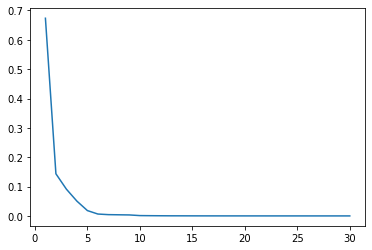

In [28]:
plt.plot(range(1, n_components + 1), explained_variance)

### <span style="color:blue">Notes about Scree Plot</span>
Explained variance tells us how much information can be attributed to each of the principal components. The explained variance reduces as the number of components increases which shows that most of the information is held by the first 5 components. 
The "elbow" of the graph is where the value of explained variance seems to level off and factors or components to the left of this point should be retained as significant.


## <span style="color:blue"> Q.2 </span>
**From the scree plot above, the best dimensionality is 5**

In [29]:
%%time
# Building optimal PCA model
columns = ['PC_1','PC_2','PC_3','PC_4','PC_5']
pca = PCA(n_components=5)
pca_train = pca.fit_transform(train_embedding_stem.iloc[:,:].values)
pca_train = pd.DataFrame(pca_train, columns = columns)
pca_train.index = train_embedding_stem.index
pca_train.head()

Wall time: 33 ms


,PC_1,PC_2,PC_3,PC_4,PC_5
Word,,,,,
pdo,-0.083510,-0.108253,0.050323,-0.157001,-0.040468
last,2.819904,-2.323350,1.826712,-1.381532,0.620075
switch,-0.589701,0.131284,0.000427,0.031251,0.037443
cool,2.864101,-0.508353,1.517785,-0.587547,-0.215213
phase,1.669828,-0.180741,-0.128614,-0.078457,0.035847


In [30]:
%%time
pca_test = pca.transform(test_embedding_stem.iloc[:,:].values)
pca_test = pd.DataFrame(pca_test, columns = columns)
pca_test.index = test_embedding_stem.index
pca_test.head()

Wall time: 2 ms


,PC_1,PC_2,PC_3,PC_4,PC_5
Word,,,,,
trenberth,-0.890984,0.001423,0.063491,-0.036722,-0.004286
view,1.193878,0.053674,-0.462494,-0.346865,-0.138315
clarifi,-1.283384,0.020650,0.113182,-0.028934,-0.025395
paper,2.147941,0.008509,-1.539193,-0.477785,-0.000630
imper,-0.962397,0.007701,0.036301,-0.049047,-0.032961


## <span style="color:blue">Q.3 </span>

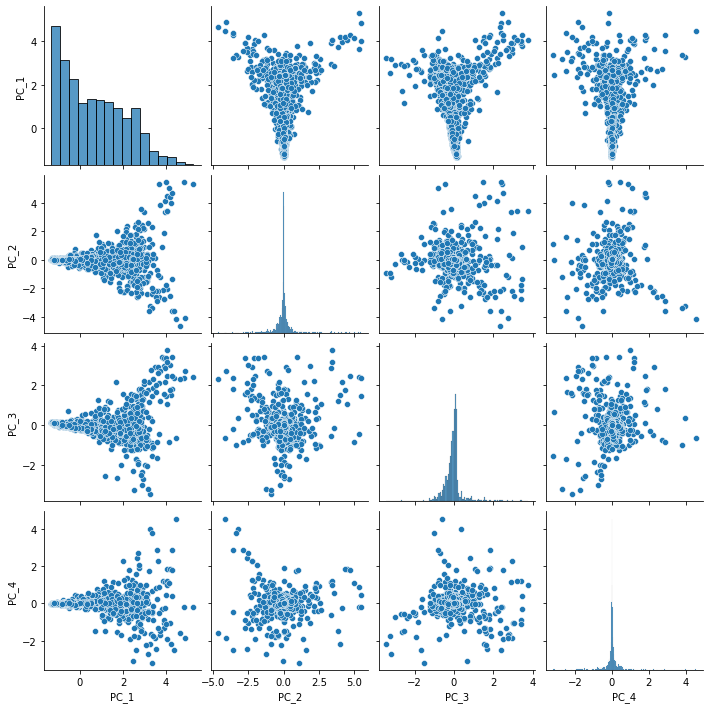

In [31]:
sns.pairplot(pca_test.iloc[:,0:4])

### <span style="color:blue">Discussion on PCA embeddings [STEMMING]</span> 
- The first principle component is highly skewed to the left. It has a lot of variance, this is likely because about 70% of the variance in the data comes from this feature
- The variance in the second, third and fourth principal components is quite small
- The first four principal components have little or no correlation with each other. 
- The largest range of embeddings in 10.6
- PCA taining speed was 33ms while the transforming of the test set took 2ms. 


### Using Lemmatization

In [32]:
pca = PCA(n_components=30)
pca.fit_transform(train_embedding_lem.iloc[:,:].values)
explained_variance = pca.explained_variance_ratio_

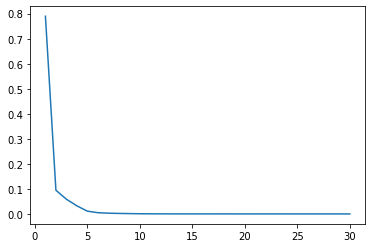

In [33]:
plt.plot(range(1, n_components + 1), explained_variance)

### <span style="color:blue">Notes about Scree Plot</span>
Explained variance tells us how much information can be attributed to each of the principal components. The explained variance reduces as the number of components increases which shows that most of the information is held by the first 5 components. 
The "elbow" of the graph is where the value of explained variance seems to level off and factors or components to the left of this point should be retained as significant.


In [34]:
%%time
# Building optimal PCA model
pca = PCA(n_components=5)
pca_train_lem = pca.fit_transform(train_embedding_lem.iloc[:,:].values)
pca_train_lem = pd.DataFrame(pca_train_lem, columns = columns)
pca_train_lem.index = train_embedding_lem.index
pca_train_lem.head()

Wall time: 34 ms


,PC_1,PC_2,PC_3,PC_4,PC_5
Word,,,,,
pdo,0.320451,-0.016940,-0.004102,-0.128489,-0.073168
last,3.611756,-2.297777,1.635421,-1.583785,0.539240
switch,-0.229129,0.100527,0.002469,0.024669,0.036328
cool,3.738706,-0.748401,1.201551,-0.541918,-0.291188
phase,2.211786,-0.025988,-0.204429,-0.184994,0.009658


In [35]:
%%time
pca_test_lem = pca.transform(test_embedding_lem.iloc[:,:].values)
pca_test_lem = pd.DataFrame(pca_test_lem, columns = columns)
pca_test_lem.index = test_embedding_lem.index
pca_test_lem.head()

Wall time: 3 ms


,PC_1,PC_2,PC_3,PC_4,PC_5
Word,,,,,
trenberth,-0.384627,0.065187,-0.016495,-0.003597,0.005849
view,1.624084,0.178001,-0.156168,-0.364315,-0.133887
clarify,-0.855369,-0.031719,0.028284,0.001837,-0.006248
paper,2.955323,0.385661,-1.091513,-0.633465,-0.087832
imperative,-0.864130,-0.021895,0.032263,0.002047,-0.009794


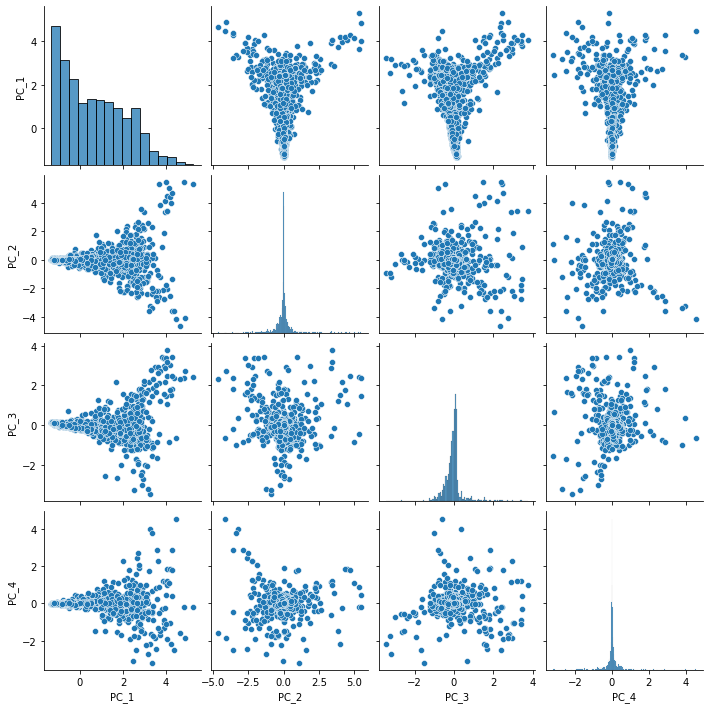

In [36]:
sns.pairplot(pca_test.iloc[:,0:4])

### <span style="color:blue">Discussion on PCA embeddings [LEMMATIZING]</span> 
- The plots are very similar to the plots from stemming
- The first principle component is highly skewed to the left. It has a lot of variance, this is likely because about 70% of the variance in the data comes from this feature
- The variance in the second, third and fourth principal components is quite small
- The first four principal components have little or no correlation with each other. 
- The largest range of embeddings in 10.6
- PCA taining speed was 34ms while the transforming of the test set took 3ms. 

## <span style="color:blue">Q.4 Cosine Similarity PCA </span>

### Getting Cosine Similarity from word2vec Embeddings

#### Getting Cosine similarity between all  words in test set [STEMMING]

In [37]:
# set cosine similarity threshold for defining similar words for comparing the different embeddings
cos_threshold = 0.99 

In [38]:
cos_sim_w2v = cosine_similarity(test_embedding_stem.iloc[:,:].values, Y=None, dense_output=True)
cos_sim_w2v.shape

(1291, 1291)

In [39]:
cos_sim_w2v = pd.DataFrame(cos_sim_w2v, 
                           columns = list(test_embedding_stem.index), 
                           index = list(test_embedding_stem.index)
                          )
cos_sim_w2v.head()

,trenberth,view,clarifi,paper,imper,climat,chang,plan,track,earth,...,tropospher,moreov,coldest,donald,hoax,classic,feast,follow,coupl,recoveri
trenberth,1.000000,0.986095,0.887195,0.949885,0.988529,0.732192,0.731838,0.981835,0.956087,0.842653,...,0.899860,0.967502,0.941495,0.993934,0.985307,0.993251,0.967167,0.972582,0.984280,0.992507
view,0.986095,1.000000,0.911144,0.975003,0.994661,0.820323,0.811189,0.970120,0.930023,0.807093,...,0.870475,0.938515,0.907052,0.989703,0.994169,0.984882,0.948655,0.940802,0.980083,0.981186
clarifi,0.887195,0.911144,1.000000,0.899639,0.907879,0.789304,0.779429,0.883671,0.805165,0.712546,...,0.792357,0.833851,0.782421,0.892884,0.911076,0.888932,0.834707,0.822188,0.876049,0.887682
paper,0.949885,0.975003,0.899639,1.000000,0.974456,0.811218,0.765248,0.942493,0.887256,0.669474,...,0.769246,0.906041,0.859607,0.967996,0.970744,0.964493,0.906650,0.885762,0.961856,0.947785
imper,0.988529,0.994661,0.907879,0.974456,1.000000,0.789838,0.782177,0.973528,0.938404,0.794359,...,0.862390,0.948271,0.916553,0.992182,0.992349,0.990346,0.954221,0.949420,0.985393,0.983740


In [40]:
# create a dataframe of similar words if cosine similarity > cos_threshold
cos_similar_stem = (cos_sim_w2v > cos_threshold).astype(int)
cos_similar_stem.head()

,trenberth,view,clarifi,paper,imper,climat,chang,plan,track,earth,...,tropospher,moreov,coldest,donald,hoax,classic,feast,follow,coupl,recoveri
trenberth,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
view,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
clarifi,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
paper,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
imper,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,0


##### Getting the most similar word from cosine similarity [STEMMING]

In [41]:
cos_most_similar_stem = get_most_similar_words(cos_sim_w2v, n_similar = 5)
cos_most_similar_stem.head()

,most_similar_1,most_similar_2,most_similar_3,most_similar_4,most_similar_5
trenberth,argu,conspiraci,fact,know,thought
view,said,contradict,un,disput,mani
clarifi,understand,un,group,describ,view
paper,journal,research,articl,scienc,publish
imper,said,say,challeng,think,conclus


#### Getting Cosine similarity between all  words in test set [LEMMATIZING]

In [42]:
cos_sim_w2v_lem = cosine_similarity(test_embedding_lem.iloc[:,:].values, Y=None, dense_output=True)
cos_sim_w2v_lem.shape

(1364, 1364)

In [43]:
cos_sim_w2v_lem = pd.DataFrame(cos_sim_w2v_lem, 
                           columns = list(test_embedding_lem.index), 
                           index = list(test_embedding_lem.index)
                          )
cos_sim_w2v_lem.head()

,trenberth,view,clarify,paper,imperative,climate,change,plan,track,earth,...,moreover,coldest,donald,hoax,classic,feast,river,follow,couple,recovery
trenberth,1.000000,0.981124,0.936998,0.969893,0.944111,0.979678,0.990865,0.995793,0.956631,0.831604,...,0.964738,0.847392,0.981072,0.994038,0.993694,0.955897,0.985677,0.951598,0.946749,0.949763
view,0.981124,1.000000,0.933068,0.978201,0.923853,0.980610,0.989329,0.976183,0.976174,0.861007,...,0.964114,0.888553,0.986916,0.990782,0.991619,0.970163,0.980880,0.958987,0.951527,0.937509
clarify,0.936998,0.933068,1.000000,0.941576,0.887340,0.950119,0.948571,0.928599,0.934848,0.746322,...,0.945303,0.857628,0.950330,0.946760,0.944163,0.935791,0.948377,0.927461,0.924432,0.921363
paper,0.969893,0.978201,0.941576,1.000000,0.928759,0.993654,0.982433,0.953798,0.952630,0.748746,...,0.960634,0.852390,0.984782,0.984130,0.978820,0.963878,0.967914,0.928946,0.939605,0.948524
imperative,0.944111,0.923853,0.887340,0.928759,1.000000,0.938000,0.939264,0.931599,0.902983,0.748239,...,0.925692,0.800496,0.931501,0.941395,0.939074,0.912092,0.930445,0.894126,0.902732,0.896420


In [44]:
# create a dataframe of similar words if cosine similarity > cos_threshold
cos_similar_lem = (cos_sim_w2v_lem > cos_threshold).astype(int)
cos_similar_lem.head()

,trenberth,view,clarify,paper,imperative,climate,change,plan,track,earth,...,moreover,coldest,donald,hoax,classic,feast,river,follow,couple,recovery
trenberth,1,0,0,0,0,0,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0
view,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
clarify,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
paper,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
imperative,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This sparse matrix of word similarity (from cosine similarity) of words from the word2vec embedding will be used as true values (labels) for evaluating the performance of the dimensionality reduction methods.

##### Getting the most similar word from cosine similarity [LEMMATIZING]

In [45]:
cos_most_similar_lem = get_most_similar_words(cos_sim_w2v_lem, n_similar=5)
cos_most_similar_lem.head()

,most_similar_1,most_similar_2,most_similar_3,most_similar_4,most_similar_5
trenberth,meet,idea,build,renewable,standard
view,certain,agreement,contradict,concept,detail
clarify,harvard,literature,phil,robert,new
paper,research,journal,warn,publish,discuss
imperative,trenberth,electricity,santer,families,represent


### Getting Cosine Similarity from PCA Embeddings

#### Getting Cosine similarity between all  words in test set [STEMMING]

In [46]:
cos_sim_pca = cosine_similarity(pca_test.iloc[:,:].values, Y=None, dense_output=False)
cos_sim_pca.shape

(1291, 1291)

In [47]:
cos_sim_pca = pd.DataFrame(cos_sim_pca, 
                           columns = list(pca_test.index), 
                           index = list(pca_test.index)
                          )
cos_sim_pca

,trenberth,view,clarifi,paper,imper,climat,chang,plan,track,earth,...,tropospher,moreov,coldest,donald,hoax,classic,feast,follow,coupl,recoveri
trenberth,1.000000,-0.904800,0.999470,-0.830558,0.998943,-0.550171,-0.555774,-0.947326,0.957280,-0.769447,...,-0.724223,0.998225,0.598230,0.822017,0.927177,0.998314,0.999128,-0.962687,-0.719589,0.991454
view,-0.904800,1.000000,-0.912388,0.960446,-0.888078,0.809737,0.764081,0.890445,-0.884670,0.597100,...,0.507663,-0.924940,-0.592789,-0.554879,-0.707369,-0.894894,-0.920122,0.819896,0.813939,-0.888241
clarifi,0.999470,-0.912388,1.000000,-0.842599,0.998200,-0.554041,-0.553719,-0.947241,0.952834,-0.761939,...,-0.707835,0.999034,0.584521,0.804847,0.924837,0.997071,0.999751,-0.963882,-0.735436,0.990969
paper,-0.830558,0.960446,-0.842599,1.000000,-0.810266,0.738899,0.644748,0.875034,-0.812036,0.379551,...,0.327614,-0.850282,-0.546796,-0.394303,-0.604021,-0.805667,-0.849870,0.754386,0.878739,-0.791115
imper,0.998943,-0.888078,0.998200,-0.810266,1.000000,-0.518838,-0.526675,-0.941970,0.953102,-0.785734,...,-0.739012,0.996071,0.584485,0.835121,0.941785,0.998637,0.997088,-0.966587,-0.701996,0.991972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
classic,0.998314,-0.894894,0.997071,-0.805667,0.998637,-0.547639,-0.561984,-0.934134,0.954996,-0.805005,...,-0.751350,0.996708,0.592391,0.841551,0.936631,1.000000,0.996650,-0.960898,-0.691307,0.994757
feast,0.999128,-0.920122,0.999751,-0.849870,0.997088,-0.572127,-0.570663,-0.949500,0.956231,-0.760405,...,-0.707588,0.999650,0.594695,0.800206,0.917167,0.996650,1.000000,-0.958679,-0.736042,0.989844
follow,-0.962687,0.819896,-0.963882,0.754386,-0.966587,0.374792,0.391091,0.854168,-0.848233,0.736529,...,0.614133,-0.954829,-0.381291,-0.782157,-0.964685,-0.960898,-0.958679,1.000000,0.771850,-0.975622
coupl,-0.719589,0.813939,-0.735436,0.878739,-0.701996,0.488334,0.411012,0.667360,-0.574431,0.243049,...,0.043785,-0.731703,-0.147149,-0.244878,-0.590203,-0.691307,-0.736042,0.771850,1.000000,-0.719128


##### Getting the most similar word from cosine similarity [STEMMING]

In [48]:
cos_most_sim_pca_stem = get_most_similar_words(cos_sim_pca, n_similar=5)
cos_most_sim_pca_stem.head()

,most_similar_1,most_similar_2,most_similar_3,most_similar_4,most_similar_5
trenberth,exagger,monckton,doom,defici,elderberri
view,challeng,expert,mani,think,said
clarifi,ripen,australasian,anyway,computer,gov
paper,publish,research,journal,novemb,sign
imper,denier,anticip,exagger,pollard,notion


In [49]:
# create a dataframe of similar words if cosine similarity > cos_threshold
cos_sim_pca_label = (cos_sim_pca > cos_threshold).astype(int)
cos_sim_pca_label.head()

,trenberth,view,clarifi,paper,imper,climat,chang,plan,track,earth,...,tropospher,moreov,coldest,donald,hoax,classic,feast,follow,coupl,recoveri
trenberth,1,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
view,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
clarifi,1,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
paper,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
imper,1,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1


#### Comparing the cosine similarity sparse matrix of PCA with word2vec [STEMMING]

In [50]:
precision_recall_fscore(cos_similar_stem, cos_sim_pca_label)

Precision:  0.78
Recall:  0.64
F1_score:  0.57


#### Getting Cosine similarity between all  words in test set [LEMMATIZING]

In [51]:
cos_sim_pca_lem = cosine_similarity(pca_test_lem.iloc[:,:].values, Y=None, dense_output=False)
cos_sim_pca_lem.shape

(1364, 1364)

In [52]:
cos_sim_pca_lem = pd.DataFrame(cos_sim_pca_lem, 
                           columns = list(pca_test_lem.index), 
                           index = list(pca_test_lem.index))
cos_sim_pca_lem

,trenberth,view,clarify,paper,imperative,climate,change,plan,track,earth,...,moreover,coldest,donald,hoax,classic,feast,river,follow,couple,recovery
trenberth,1.000000,-0.926113,0.975960,-0.863475,0.977849,-0.912885,-0.942733,-0.903562,-0.597315,-0.853764,...,0.972628,-0.203022,-0.485910,-0.080364,0.992301,0.973497,-0.963465,-0.992863,0.974127,0.978794
view,-0.926113,1.000000,-0.968612,0.967179,-0.967669,0.974934,0.981706,0.948539,0.484959,0.807299,...,-0.969958,-0.010684,0.635284,0.408047,-0.918284,-0.966052,0.959162,0.919965,-0.969085,-0.966803
clarify,0.975960,-0.968612,1.000000,-0.927385,0.999914,-0.963667,-0.987322,-0.973885,-0.470587,-0.832925,...,0.999359,-0.016066,-0.536972,-0.255299,0.983016,0.999797,-0.991877,-0.977633,0.999950,0.999713
paper,-0.863475,0.967179,-0.927385,1.000000,-0.927524,0.992238,0.973719,0.921551,0.490511,0.636042,...,-0.922362,-0.044978,0.787255,0.556802,-0.855632,-0.924411,0.949300,0.885112,-0.929691,-0.923357
imperative,0.977849,-0.967669,0.999914,-0.927524,1.000000,-0.964135,-0.987310,-0.971537,-0.480770,-0.830481,...,0.998888,-0.027416,-0.541754,-0.250458,0.983874,0.999534,-0.992673,-0.980084,0.999813,0.999656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feast,0.973497,-0.966052,0.999797,-0.924411,0.999534,-0.961522,-0.986243,-0.976998,-0.453937,-0.832644,...,0.999432,0.000357,-0.526854,-0.256707,0.983034,1.000000,-0.991262,-0.975506,0.999841,0.999535
river,-0.963465,0.959162,-0.991877,0.949300,-0.992673,0.980860,0.992827,0.966231,0.497190,0.757653,...,-0.987308,0.023688,0.615553,0.309223,-0.969389,-0.991262,1.000000,0.979221,-0.992557,-0.990970
follow,-0.992863,0.919965,-0.977633,0.885112,-0.980084,0.933047,0.955142,0.912661,0.598211,0.793750,...,-0.971318,0.186503,0.544072,0.126832,-0.988541,-0.975506,0.979221,1.000000,-0.976566,-0.979434
couple,0.974127,-0.969085,0.999950,-0.929691,0.999813,-0.965341,-0.988353,-0.975449,-0.465707,-0.828774,...,0.999250,-0.008400,-0.540441,-0.263635,0.981841,0.999841,-0.992557,-0.976566,1.000000,0.999605


#### Comparing most similar words in PCA to Word2Vec most similar words [LEMMATIZING]

In [53]:
cos_most_sim_pca_lem = get_most_similar_words(cos_sim_pca_lem, n_similar=5)
cos_most_sim_pca_lem.head()

,most_similar_1,most_similar_2,most_similar_3,most_similar_4,most_similar_5
trenberth,filter,associate,legal,company,drastic
view,certain,agreement,context,fail,note
clarify,gravity,readout,feb,enormous,highly
paper,research,publish,discuss,warn,journal
imperative,draconian,mack,decision,production,stalagmites


In [54]:
# create a dataframe of similar words if cosine similarity > cos_threshold
cos_sim_pca_lem_label = (cos_sim_pca_lem > cos_threshold).astype(int)
cos_sim_pca_lem_label.head()

,trenberth,view,clarify,paper,imperative,climate,change,plan,track,earth,...,moreover,coldest,donald,hoax,classic,feast,river,follow,couple,recovery
trenberth,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
view,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
clarify,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,1
paper,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
imperative,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,1


#### Comparing the cosine similarity sparse matrix of PCA with word2vec [LEMMATIZING]

In [55]:
precision_recall_fscore(cos_similar_lem, cos_sim_pca_lem_label)

Precision:  0.69
Recall:  0.62
F1_score:  0.51


### <span style="color:blue">Comparing Evaluation Metrics for Cosine Similarity of PCA embeddings</span>


|  | Precision | Recall | F1 Score |
| --- | --- | --- |--- |
|  PCA Embeddings of Stemmed Words  | 0.78 | 0.64 | 0.57|
|   PCA Embeddings of Lemmatized Words | 0.69 | 0.62 | 0.51|

Comparing the cosine similarity, Stemming performed better than Lemmatizing

In [56]:
words_list = [['man', 'bear'],['heat', 'warm'],['earth', 'global'], ['cold', 'warm'], ['summer', 'ocean'], ['summer', 'winter']]
for word in words_list:
    print("The Cos similarity of stemmed PCA embeddings between", word[0], "and", word[1], "is", round(cos_sim_pca.at[word[0], word[1]],2))
    print("The Cos similarity of lemmatized PCA embeddings between", word[0], "and", word[1], "is", round(cos_sim_pca_lem.at[word[0], word[1]],2))
    similarity(words = word, 
               stem_model = model_stem, 
               lem_model = model_lem
              )
    print("\n")

The Cos similarity of stemmed PCA embeddings between man and bear is 0.73
The Cos similarity of lemmatized PCA embeddings between man and bear is 0.91
Stemmed W2V model similarity between man and bear = 0.94
Lemmatized W2V model similarity between man and bear = 0.96


The Cos similarity of stemmed PCA embeddings between heat and warm is 0.49
The Cos similarity of lemmatized PCA embeddings between heat and warm is 0.64
Stemmed W2V model similarity between heat and warm = 0.62
Lemmatized W2V model similarity between heat and warm = 0.69


The Cos similarity of stemmed PCA embeddings between earth and global is 0.94
The Cos similarity of lemmatized PCA embeddings between earth and global is 0.95
Stemmed W2V model similarity between earth and global = 0.94
Lemmatized W2V model similarity between earth and global = 0.94


The Cos similarity of stemmed PCA embeddings between cold and warm is 0.48
The Cos similarity of lemmatized PCA embeddings between cold and warm is 0.57
Stemmed W2V model

### <span style="color:blue">Analysis of Cosine similarity</span>

1. **Man and Bear**

These words are not similar, an ideal similarity should be 0.5 or less. The PCA embeddings of stemmed words produced a similarity of 0.73, while the PCA embeddings of lemmatized words produced a similarity of 0.91. This should not be the case considering that these words are not similar. The stemmed Word2Vec model produces a similarity of 0.94 while the lemmatized Word2Vec model produces a similarity of 0.96.

2. **Heat and Warm**

These words are similar, an ideal similarity value should be about 0.7 or 0.8. The PCA embeddings of stemmed words produced a similarity of 0.49,  while the PCA embeddings of lemmatized words produced a similarity of 0.64. This is close to our expectation, but not good enough. However, the stemmed Word2Vec model produces a similarity of 0.62 while the lemmatized Word2Vec model produces a similarity of 0.69.

3. **Earth and Global**

These words have a similar context, an ideal similarity value should be about 0.8. The PCA embeddings of stemmed words produced a similarity of 0.94, while the PCA embeddings of lemmatized words produced a similarity of 0.95. However, the stemmed Word2Vec model produces a similarity of 0.94 while the lemmatized Word2Vec model produces a similarity of 0.94. All the similarities here are slightly higher than our expectation. 

4. **Cold and Warm**

These words are not similar, an ideal similarity should be 0.5 or less. The PCA embeddings of stemmed words produced a similarity of 0.47, while the PCA embeddings of lemmatized words produced a similarity of 0.59. The PCA model performed well with the relationship. The stemmed Word2Vec model produces a similarity of 0.66 while the lemmatized Word2Vec model produces a similarity of 0.69.

5. **Summer and Ocean**

These words are not similar, an ideal similarity should be 0.6 or less. The PCA embeddings of stemmed words produced a similarity of 0.55, while the PCA embeddings of lemmatized words produced a similarity of 0.7. This should not be the case considering that these words are not similar. The stemmed Word2Vec model produces a similarity of 0.71 while the lemmatized Word2Vec model produces a similarity of 0.78.

6. **Summer and Winter**

These words are opposites, an ideal similarity should be less than 0.5. The PCA embeddings of stemmed words produced a similarity of 0.99, while the PCA embeddings of lemmatized words produced a similarity of 0.99.  The stemmed Word2Vec model produces a similarity of 0.99 while the lemmatized Word2Vec model produces a similarity of 0.99. This should not be the case considering that these words are not similar.

**Summmary of Analysis**

| Words | Stemmed PCA | Lemmatized PCA | Stemmed Word2Vec | Lemmatized Word2Vec |
| --- | --- | --- |--- |-- |
|   Man, Bear | **0.73** | 0.91 | 0.94 | 0.96 |
|   Heat, Warm| 0.49 | 0.64 | 0.62 | **0.69**|
|   Earth, Global | 0.94 | **0.95** | 0.94 | 0.94|
|   Cold, Warm | **0.48** | 0.57 | 0.67 | 0.67|
|   Summer, Ocean | **0.55** | 0.7 | 0.71 | 0.78|
|   Summer, Winter| 0.99 | 0.99 | 0.99 | 0.99|


*Best performing model in bold*

## KNN GRAPH (Word2Vec)

#### Using KNN on word embedding to get most similar word [STEMMING]

In [57]:
knn_similar_stem = kneighbors_graph(test_embedding_stem.iloc[:,:].values, 6, mode='connectivity', include_self=True)

In [58]:
knn_similar_stem = pd.DataFrame(knn_similar_stem.toarray(), 
                    columns = list(test_embedding_stem.index), 
                    index = list(test_embedding_stem.index)
                   )
knn_similar_stem.head()

,trenberth,view,clarifi,paper,imper,climat,chang,plan,track,earth,...,tropospher,moreov,coldest,donald,hoax,classic,feast,follow,coupl,recoveri
trenberth,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
view,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
clarifi,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
paper,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
imper,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
knn_most_similar_stem = get_most_similar_words(knn_similar_stem, n_similar=5)
knn_most_similar_stem.head()

,most_similar_1,most_similar_2,most_similar_3,most_similar_4,most_similar_5
trenberth,rooftop,chimney,anyon,seawal,sulphur
view,statist,emerg,question,independ,repres
clarifi,gov,reanalys,ellipt,julia,accret
paper,studi,issu,peer,public,accord
imper,profession,harvard,deconto,hook,watson


#### Using KNN on word embedding to get most similar word [LEMMATIZING]

In [60]:
knn_similar_lem = kneighbors_graph(test_embedding_lem.iloc[:,:].values, 6, mode='connectivity', include_self=True)

In [61]:
knn_similar_lem = pd.DataFrame(knn_similar_lem.toarray(), 
                    columns = list(test_embedding_lem.index), 
                    index = list(test_embedding_lem.index)
                   )
knn_similar_lem.head()

,trenberth,view,clarify,paper,imperative,climate,change,plan,track,earth,...,moreover,coldest,donald,hoax,classic,feast,river,follow,couple,recovery
trenberth,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
view,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
clarify,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
paper,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
imperative,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
knn_most_similar_lem = get_most_similar_words(knn_similar_lem, n_similar=5)
knn_most_similar_lem.head()

,most_similar_1,most_similar_2,most_similar_3,most_similar_4,most_similar_5
trenberth,cook,super,aerosols,associate,drastic
view,become,cosmic,likely,question,urban
clarify,statistics,integrity,interactive,feb,mack
paper,number,peer,first,public,accord
imperative,simulations,conducive,feb,citation,steady


The KNN Neighbors of words from the word2vec embedding will be used as true labels for comparing dimensionality reduction methods

## KNN GRAPH (PCA)

#### Using KNN on word embedding to get most similar word [STEMMING]

In [63]:
knn_similar_stem_pca = kneighbors_graph(pca_test.iloc[:,:].values, 6, mode='connectivity', include_self=True)

In [64]:
knn_similar_stem_pca = pd.DataFrame(knn_similar_stem_pca.toarray(), 
                    columns = list(pca_test.index), 
                    index = list(pca_test.index)
                   )
knn_similar_stem_pca.head()

,trenberth,view,clarifi,paper,imper,climat,chang,plan,track,earth,...,tropospher,moreov,coldest,donald,hoax,classic,feast,follow,coupl,recoveri
trenberth,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
view,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
clarifi,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
paper,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
imper,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Comparing most similar words in PCA to Word2Vec most similar words [STEMMING]

In [65]:
knn_most_similar_stem_pca = get_most_similar_words(knn_similar_stem_pca, n_similar=5)
knn_most_similar_stem_pca.head()

,most_similar_1,most_similar_2,most_similar_3,most_similar_4,most_similar_5
trenberth,rooftop,chimney,anyon,seawal,sulphur
view,statist,emerg,question,independ,pari
clarifi,gov,reanalys,ellipt,julia,predetermin
paper,studi,issu,peer,public,accord
imper,profession,harvard,deconto,hook,watson


In [66]:
precision_recall_fscore(knn_similar_stem, knn_similar_stem_pca)

Precision:  0.94
Recall:  0.95
F1_score:  0.94


#### Using KNN on word embedding to get most similar word [LEMMATIZING]

In [67]:
knn_similar_lem_pca = kneighbors_graph(pca_test_lem.iloc[:,:].values, 2, mode='connectivity', include_self=True)

In [68]:
knn_similar_lem_pca = pd.DataFrame(knn_similar_lem_pca.toarray(), 
                    columns = list(pca_test_lem.index), 
                    index = list(pca_test_lem.index)
                   )
knn_similar_lem_pca.head()

,trenberth,view,clarify,paper,imperative,climate,change,plan,track,earth,...,moreover,coldest,donald,hoax,classic,feast,river,follow,couple,recovery
trenberth,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
view,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
clarify,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
paper,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
imperative,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Comparing most similar words in PCA to Word2Vec most similar words [LEMMATIZING]

In [69]:
knn_most_similar_lem_pca = get_most_similar_words(knn_similar_lem_pca, n_similar=5)
knn_most_similar_lem_pca.head()

,most_similar_1,most_similar_2,most_similar_3,most_similar_4,most_similar_5
trenberth,drastic,view,clarify,paper,imperative
view,likely,trenberth,clarify,paper,imperative
clarify,feb,trenberth,view,paper,imperative
paper,accord,trenberth,view,clarify,imperative
imperative,citation,trenberth,view,clarify,paper


In [70]:
precision_recall_fscore(knn_similar_lem, knn_similar_lem_pca)

Precision:  0.99
Recall:  0.7
F1_score:  0.76


### <span style="color:blue">Comparing Evaluation Metrics for KNN Graph of PCA embeddings</span>


|  | Precision | Recall | F1 Score |
| --- | --- | --- |--- |
|  PCA Embeddings of Stemmed Words  | 0.94 | 0.95 | 0.94|
|   PCA Embeddings of Lemmatized Words | 0.99 | 0.7 | 0.76|

<br>
The stemmed PCA model performs better that the lemmatized PCA model.<br>
The lemmatized PCA model has a high precision but a low recall which results to a low fscore.


## KNN CLASSIFICATION OF THE CLAIMS USING PCA EMBEDDINGS

#### Applying KNN on the PCA Sentence Embeddings [STEMMING]

In [90]:
# Dropping rows with mislabeled claims
outlier_index = train_data[train_data["claim_label"] == 3].index
train_data.drop(outlier_index, inplace = True)
train_data.reset_index(drop = True, inplace=True)
train_data.shape

(1108, 4)

In [91]:
outlier_index = test_data[test_data["claim_label"] == 3].index
test_data.drop(outlier_index, inplace = True)
test_data.reset_index(drop = True, inplace=True)
test_data.shape

(273, 4)

In [92]:
knn_train_stem = train_data[['claim', 'stemmed_words', 'claim_label']]
knn_test_stem = test_data[['claim', 'stemmed_words', 'claim_label']]

# getting the sentence embedding of the training data
knn_train_stem = get_sentence_embedding(knn_train_stem, 'stemmed_words', pca_train, pca_test)
knn_train_stem.shape

(1108, 7)

In [93]:
knn_train_stem.head()

,claim,feature_1,feature_2,feature_3,feature_4,feature_5,claim_label
0,"When the PDO last switched to a cool phase, gl...",2.304605,-0.967967,1.320831,-0.705482,0.028813,2
1,as time progresses and fossil fuel emissions i...,2.961435,0.381129,0.667582,0.084079,0.196214,2
2,Hurricanes aren't linked to global warming,2.517299,0.087590,1.209453,-0.943510,-0.731021,2
3,Ljungqvist's millennial temperature reconstruc...,0.576780,-0.462915,0.283831,-0.155504,0.014352,2
4,"More importantly, the OISM list only contains ...",0.872608,0.297925,-0.755649,-0.485208,-0.282169,2


In [94]:
knn_test_stem = get_sentence_embedding(knn_test_stem, 'stemmed_words', pca_train, pca_test)
knn_test_stem.shape

(273, 7)

In [95]:
knn_test_stem.head()

,claim,feature_1,feature_2,feature_3,feature_4,feature_5,claim_label
0,"Trenberth's views are clarified in the paper ""...",1.220409,0.508363,-0.070640,-0.563402,-0.386888,0
1,"When life is considered, ocean acidification i...",1.739670,0.122007,-0.117421,0.294819,0.021619,1
2,In recent decades this warming has been accomp...,2.374765,-0.501875,0.912189,-0.263308,-0.521272,0
3,while it’s true that studies in some regions s...,1.501689,-0.638804,-0.285267,0.358604,-0.162167,1
4,It is unclear whether global warming is increa...,2.409271,0.320484,1.263103,-0.593837,-0.458476,0


In [96]:
X_train = knn_train_stem.iloc[:,1:-1].values
y_train = knn_train_stem.iloc[:,-1].values
X_test = knn_test_stem.iloc[:,1:-1].values
y_test = knn_test_stem.iloc[:,-1].values

In [97]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

##### Getting the optimal value for K

***** Training Set Evaluation *****

confusion Matrix


,0,1,2
0,444,25,56
1,118,65,20
2,166,26,188


Accuracy:  62.91
F1_score:  0.61


***** Test Set Evaluation *****

confusion Matrix


,0,1,2
0,55,2,8
1,14,6,4
2,35,3,10


Accuracy:  51.82
F1_score:  0.47


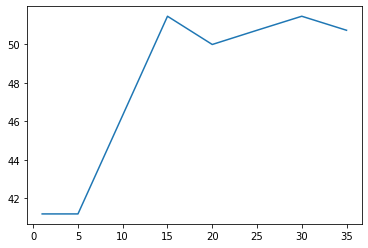

In [98]:
run_knn_opt(X_train, X_val, X_test, y_train, y_val, y_test, [1,5,10,15,20,25,30,35])

##### Building model with the optimal value for K

In [99]:
k_opt = 15

classifier = KNeighborsClassifier(n_neighbors = k_opt)
classifier.fit(X_train,y_train)

# Predicting the test set result
y_pred = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)
y_pred_val = classifier.predict(X_val)


# Evaluating the model
accuracy_test = round(100 * accuracy_score(y_test, y_pred), 2)
cm_test = pd.DataFrame(confusion_matrix(y_test,y_pred))
PRF_test = precision_recall_fscore_support(y_test, y_pred, average='weighted')

accuracy_train = round(100 * accuracy_score(y_train, y_pred_train), 2)
cm_train = pd.DataFrame(confusion_matrix(y_train,y_pred_train))
PRF_train = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')

accuracy_val = round(100 * accuracy_score(y_val, y_pred_val), 2)
cm_val = pd.DataFrame(confusion_matrix(y_val,y_pred_val))
PRF_val = precision_recall_fscore_support(y_val, y_pred_val, average='weighted')

print("***** Test Set Evaluation *****")
print("Confusion Matrix")
display(cm_test)
print("Accuracy: ", accuracy_test)
print("Precision: ", round(PRF_test[0], 2))
print("Recall: ", round(PRF_test[1], 2))
print("F1_score: ", round(PRF_test[2], 2))

print()

print("***** Training Set Evaluation *****")
print("Confusion Matrix")
display(cm_train)
print("Accuracy: ", accuracy_train)
print("Precision: ", round(PRF_train[0], 2))
print("Recall: ", round(PRF_train[1], 2))
print("F1_score: ", round(PRF_train[2], 2))
print()

print("***** Validation Set Evaluation *****")
print("Confusion Matrix")
display(cm_val)
print("Accuracy: ", accuracy_val)
print("Precision: ", round(PRF_val[0], 2))
print("Recall: ", round(PRF_val[1], 2))
print("F1_score: ", round(PRF_val[2], 2))

***** Test Set Evaluation *****
Confusion Matrix


,0,1,2
0,58,1,6
1,19,3,2
2,33,2,13


Accuracy:  54.01
Precision:  0.55
Recall:  0.54
F1_score:  0.48

***** Training Set Evaluation *****
Confusion Matrix


,0,1,2
0,429,12,84
1,147,21,35
2,242,11,127


Accuracy:  52.08
Precision:  0.51
Recall:  0.52
F1_score:  0.47

***** Validation Set Evaluation *****
Confusion Matrix


,0,1,2
0,47,3,14
1,18,2,6
2,25,0,21


Accuracy:  51.47
Precision:  0.5
Recall:  0.51
F1_score:  0.48


#### Applying KNN Classification on the PCA Embeddings [LEMMATIZATION]

In [100]:
knn_train_lem = train_data[['claim', 'lemmatized_words', 'claim_label']]
knn_test_lem = test_data[['claim', 'lemmatized_words', 'claim_label']]

In [101]:
# getting the sentence embedding of the training data
knn_train_lem = get_sentence_embedding(knn_train_lem, 'lemmatized_words', pca_train_lem, pca_test_lem)
knn_train_lem.shape

(1108, 7)

In [102]:
knn_train_lem.head()

,claim,feature_1,feature_2,feature_3,feature_4,feature_5,claim_label
0,"When the PDO last switched to a cool phase, gl...",2.462266,-0.831696,0.873716,-0.555186,-0.064936,2
1,as time progresses and fossil fuel emissions i...,2.889612,0.471560,0.072281,0.169673,0.172425,2
2,Hurricanes aren't linked to global warming,2.367886,0.102642,1.665804,-0.736424,-0.877432,2
3,Ljungqvist's millennial temperature reconstruc...,0.603359,-0.110147,-0.105968,-0.066657,0.026065,2
4,"More importantly, the OISM list only contains ...",1.321917,0.141455,-0.338723,-0.093238,0.029049,2


In [103]:
knn_test_lem = get_sentence_embedding(knn_test_lem, 'lemmatized_words', pca_train_lem, pca_test_lem)
knn_test_lem.shape

(273, 7)

In [104]:
knn_test_lem.head()

,claim,feature_1,feature_2,feature_3,feature_4,feature_5,claim_label
0,"Trenberth's views are clarified in the paper ""...",2.017787,0.171955,0.138198,-0.326197,-0.156192,0
1,"When life is considered, ocean acidification i...",1.997855,0.176684,-0.033770,0.177260,0.013192,1
2,In recent decades this warming has been accomp...,2.120780,-0.475521,0.590851,0.185268,-0.335002,0
3,while it’s true that studies in some regions s...,1.603195,-0.479668,-0.350677,0.253162,-0.012201,1
4,It is unclear whether global warming is increa...,1.836290,0.089946,0.716937,-0.274150,-0.345470,0


In [105]:
X_train = knn_train_lem.iloc[:,1:-1].values
y_train = knn_train_lem.iloc[:,-1].values
X_test = knn_test_lem.iloc[:,1:-1].values
y_test = knn_test_lem.iloc[:,-1].values

In [106]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

##### Getting the optimal value for K

***** Training Set Evaluation *****

confusion Matrix


,0,1,2
0,437,23,65
1,114,61,28
2,198,19,163


Accuracy:  59.66
F1_score:  0.57


***** Test Set Evaluation *****

confusion Matrix


,0,1,2
0,48,7,10
1,11,7,6
2,30,3,15


Accuracy:  51.09
F1_score:  0.49


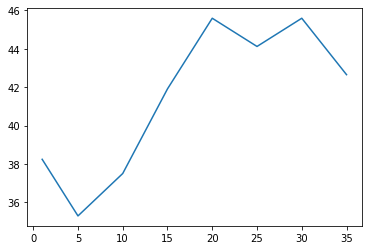

In [107]:
run_knn_opt(X_train, X_val, X_test, y_train, y_val, y_test, [1,5,10,15,20,25,30,35])

##### Building model with the optimal value for K

In [111]:
k_opt = 30

classifier = KNeighborsClassifier(n_neighbors = k_opt)
classifier.fit(X_train,y_train)

# Predicting the test set result
y_pred = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)
y_pred_val = classifier.predict(X_val)


# Evaluating the model
accuracy_test = round(100 * accuracy_score(y_test, y_pred), 2)
cm_test = pd.DataFrame(confusion_matrix(y_test,y_pred))
PRF_test = precision_recall_fscore_support(y_test, y_pred, average='weighted')

accuracy_train = round(100 * accuracy_score(y_train, y_pred_train), 2)
cm_train = pd.DataFrame(confusion_matrix(y_train,y_pred_train))
PRF_train = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')

accuracy_val = round(100 * accuracy_score(y_val, y_pred_val), 2)
cm_val = pd.DataFrame(confusion_matrix(y_val,y_pred_val))
PRF_val = precision_recall_fscore_support(y_val, y_pred_val, average='weighted')

print("***** Test Set Evaluation *****")
print("Confusion Matrix")
display(cm_test)
print("Accuracy: ", accuracy_test)
print("Precision: ", round(PRF_test[0], 2))
print("Recall: ", round(PRF_test[1], 2))
print("F1_score: ", round(PRF_test[2], 2))

print()

print("***** Training Set Evaluation *****")
print("Confusion Matrix")
display(cm_train)
print("Accuracy: ", accuracy_train)
print("Precision: ", round(PRF_train[0], 2))
print("Recall: ", round(PRF_train[1], 2))
print("F1_score: ", round(PRF_train[2], 2))
print()

print("***** Validation Set Evaluation *****")
print("Confusion Matrix")
display(cm_val)
print("Accuracy: ", accuracy_val)
print("Precision: ", round(PRF_val[0], 2))
print("Recall: ", round(PRF_val[1], 2))
print("F1_score: ", round(PRF_val[2], 2))

***** Test Set Evaluation *****
Confusion Matrix


,0,1,2
0,53,1,11
1,18,0,6
2,38,0,10


Accuracy:  45.99
Precision:  0.36
Recall:  0.46
F1_score:  0.38

***** Training Set Evaluation *****
Confusion Matrix


,0,1,2
0,445,3,77
1,150,8,45
2,261,1,118


Accuracy:  51.53
Precision:  0.54
Recall:  0.52
F1_score:  0.45

***** Validation Set Evaluation *****
Confusion Matrix


,0,1,2
0,51,1,12
1,17,2,7
2,37,0,9


Accuracy:  45.59
Precision:  0.46
Recall:  0.46
F1_score:  0.39


### <span style="color:blue"> KNN Classification for PCA</span>

- The optimal value of K in KNN classification for the stemmed PCA model was 15 and for the lemmatized PCA model, optimal k was 30. 

<br><br><br>
**PCA KNN Model Evaluation**
<br>
- Stemmed Corpus
|  | Accuracy | Precision | Recall | F1 Score |
| --- | --- | --- |--- |-- |
|   Training Set  | 52.08 | 0.51 | 0.52 | 0.47|
|   Validation| 51.47 | 0.5 | 0.51 | 0.48|
|   Test Set | 54.01 | 0.55 | 0.54 | 0.48|
<br>
- Lemmatized Corpus
|  | Accuracy | Precision | Recall | F1 Score |
| --- | --- | --- |--- |-- |
|   Training Set  | 51.53 | 0.54 | 0.52 | 0.45|
|   Validation| 45.59 | 0.46 | 0.46 | 0.39|
|   Test Set | 45.99 | 0.36 | 0.46 | 0.38|

<br><br><br>
**Word2Vec KNN Model Evaluation (From CM1)**
<br>
- Stemmed Corpus
|  | Accuracy | Precision | Recall | F1 Score |
| --- | --- | --- |--- |-- |
|   Training Set  | 50.81 | 0.52 | 0.51 | 0.45|
|   Validation| 52.21 | 0.6 | 0.52 | 0.47|
|   Test Set | 51.82 | 0.46 | 0.52 | 0.44|
<br>
- Lemmatized Corpus
|  | Accuracy | Precision | Recall | F1 Score |
| --- | --- | --- |--- |-- |
|   Training Set  | 51.9 | 0.55 | 0.52 | 0.45|
|   Validation| 46.32 | 0.45 | 0.46 | 0.4|
|   Test Set | 43.8 | 0.33 | 0.44 | 0.36|

<br><br><br>

**Comparing the PCA KNN Model to the Word2Vec KNN Model**

- The PCA model  had a better performance on the test set and also a higher training set performance but performed slightly worse on the validation set for the stemmed corpus.
- The PCA model also had a higher test set performance. It also performed better on the validation set but performed slightly less on the training set compared to the Word2Vec KNN model for the lemmatized corpus.